## Low Pass Filtering Provides Improved Smoothing

but it is more complicated to implement. These next cells are almost directly copied from the link provided and illustrates the process. The plotting parts have been built into functions so we can call them again later. Find out a little more about finite impulse response (FIR) filters at https://en.wikipedia.org/wiki/Finite_impulse_response There is a lot of math behind the design of filters, yet we can use them as black box elements as long as we test them to see how they perform in our application.

**Low Pass Filters** eliminate higher frequencies from your data, good for removing noise.

**High Pass Filters** eliminate lower frequencies from your data, good for removing 60 Hz hum from music.

**Band Pass Filters** eliminate frequencies above and below the pass band.

**Band Stop Filters** eliminate a range of frequencies while passing those outside the range.

The more coefficients you include in your filter kernel, the sharper you can make the edges of the filter, and the smaller the artifacts on either side. scipy has functions to let you specify the width of the rolloff and the size of the ripples to determine the number of taps required.

You can design a filter in Python, then take the resulting tap values to implement an FIR filter in your arduino code.

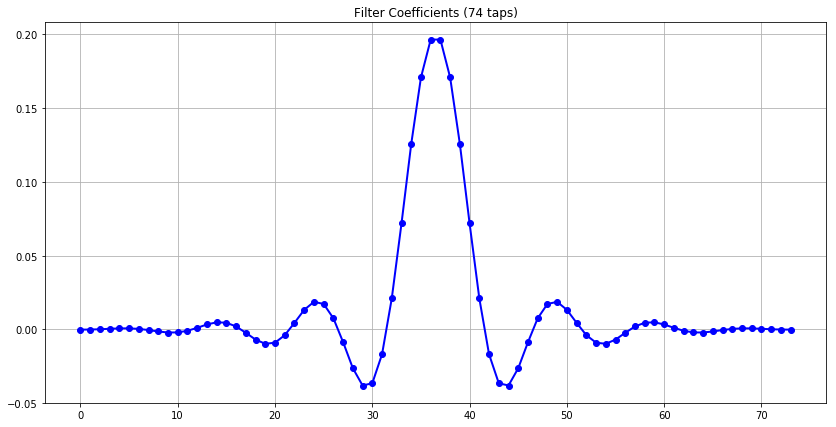

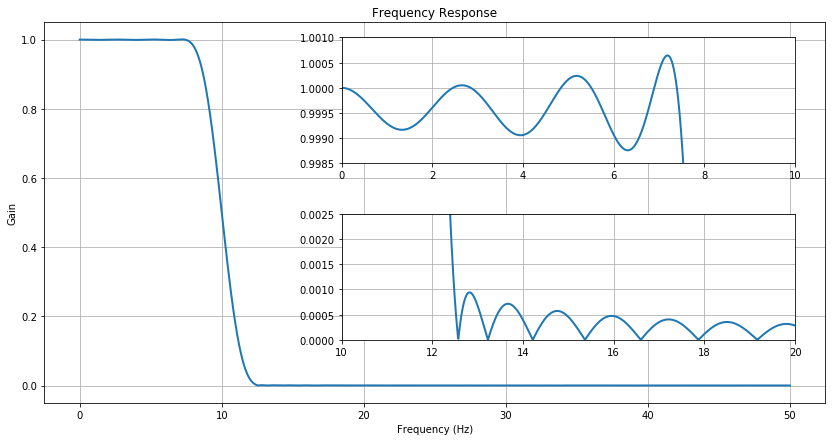

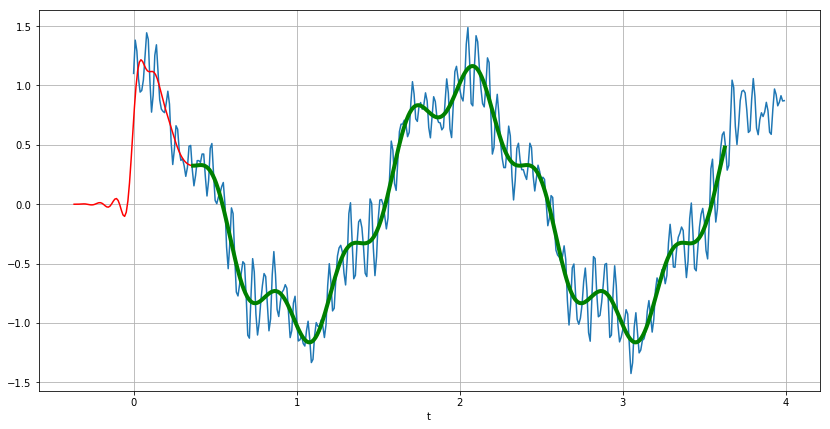

In [1]:
# Adapted from http://scipy-cookbook.readthedocs.io/items/FIRFilter.html
from numpy import *
from scipy.signal import *
from pylab import *
%matplotlib inline

# This lets you make the default figure size larger (or smaller)
from IPython.core.pylabtools import figsize
figsize(14, 7)

def plotResults():
    #------------------------------------------------
    # Plot the original and filtered signals.
    #------------------------------------------------
    figure(3)
    # Plot the original signal.
    plot(t, x)
    # Plot the filtered signal, shifted to compensate for the phase delay.
    plot(t-delay, filtered_x, 'r-')
    # Plot just the "good" part of the filtered signal.  The first N-1
    # samples are "corrupted" by the initial conditions.
    plot(t[N-1:]-delay, filtered_x[N-1:], 'g', linewidth=4)
    xlabel('t')
    grid(True)

def plotFilterFigs():      # put the polotting in a function so we can play with the effects
    #------------------------------------------------
    # Plot the FIR filter coefficients.
    #------------------------------------------------
    figure(1)
    plot(taps, 'bo-', linewidth=2)
    title('Filter Coefficients (%d taps)' % N)
    grid(True)

    #------------------------------------------------
    # Plot the magnitude response of the filter.
    #------------------------------------------------
    figure(2)
    clf()
    w, h = freqz(taps, worN=8000)
    plot((w/pi)*nyq_rate, absolute(h), linewidth=2)
    xlabel('Frequency (Hz)')
    ylabel('Gain')
    title('Frequency Response')
    ylim(-0.05, 1.05)
    grid(True)

    # Upper inset plot.
    ax1 = axes([0.42, 0.6, .45, .25])
    plot((w/pi)*nyq_rate, absolute(h), linewidth=2)
    xlim(0,10.0)
    ylim(0.9985, 1.001)
    grid(True)

    # Lower inset plot
    ax2 = axes([0.42, 0.25, .45, .25])
    plot((w/pi)*nyq_rate, absolute(h), linewidth=2)
    xlim(10.0, 20.0)
    ylim(0.0, 0.0025)
    grid(True)

    plotResults()
    show()
    
#------------------------------------------------
# Create a signal for demonstration.
#------------------------------------------------

sample_rate = 100.0
nsamples = 400
t = arange(nsamples) / sample_rate
x = cos(2*pi*0.5*t) + 0.2*sin(2*pi*2.5*t+0.1) + \
        0.2*sin(2*pi*15.3*t) + 0.1*sin(2*pi*16.7*t + 0.1) + \
            0.1*sin(2*pi*23.45*t+.8)
# The Nyquist rate of the signal.
nyq_rate = sample_rate / 2.0


#------------------------------------------------
# Create a FIR filter and apply it to x.
#------------------------------------------------

# The desired width of the transition from pass to stop,
# relative to the Nyquist rate.  We'll design the filter
# with a 5 Hz transition width.
width = 5.0/nyq_rate

# The desired attenuation in the stop band, in dB.
ripple_db = 60.0

# The cutoff frequency of the filter.
cutoff_hz = 10.0

def runFilter():
    global N,beta,taps,filtered_x,delay
    # Compute the order and Kaiser parameter for the FIR filter.
    N, beta = kaiserord(ripple_db, width)

    # Use firwin with a Kaiser window to create a lowpass FIR filter.
    taps = firwin(N, cutoff_hz/nyq_rate, window=('kaiser', beta))

    # Use lfilter to filter x with the FIR filter.
    filtered_x = lfilter(taps, 1.0, x)

    # The phase delay of the filtered signal.
    delay = 0.5 * (N-1) / sample_rate

runFilter()
plotFilterFigs()

The final plots shows the original signal (thin blue line), the filtered signal (shifted by the appropriate phase delay to align with the original signal; thin red line), and the "good" part of the filtered signal (heavy green line). The "good part" is the part of the signal that is not affected by the initial conditions, where the filter kernel doesn't fully overlap the signal.

## Now try playing with the filter parameters to find out what they do. 

This is where we learn about the properties of this black box by seeing how it performs when we "turn the knobs".

The **cutoff frequency** is the frequency where the filter transitions from passing the signal to attenuating it. The width controls the steepness of the rolloff. 

The **width parameter** times the Nyquist frequency gives the width of the rolloff in Hz, so 20/nyq_rate will give a 20 Hz rolloff. Pick a width you can live with. 5/nyq_rate is probably a good compromise.

The **ripple_db** controls the magnitude of the small oscillations on either side of the rolloff using a value in decibels of attenuation. Every 20 dB is a factor of 10 for amplitude, so choosing 60 dB will keep the ripples to less than 1/1000 of the main function.

The wider the rolloff, the fewer taps you will need. 

The larger the ripple you can tolerate, the fewer taps you will need.

Fewer taps or filter coefficients in the filter kernal means fewer calculations so the filter will run much faster. They also mean less time lag between the real time and filtered signal.

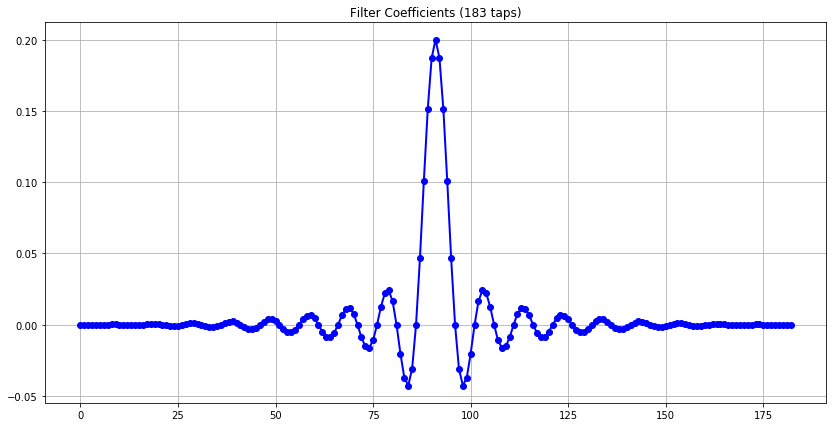

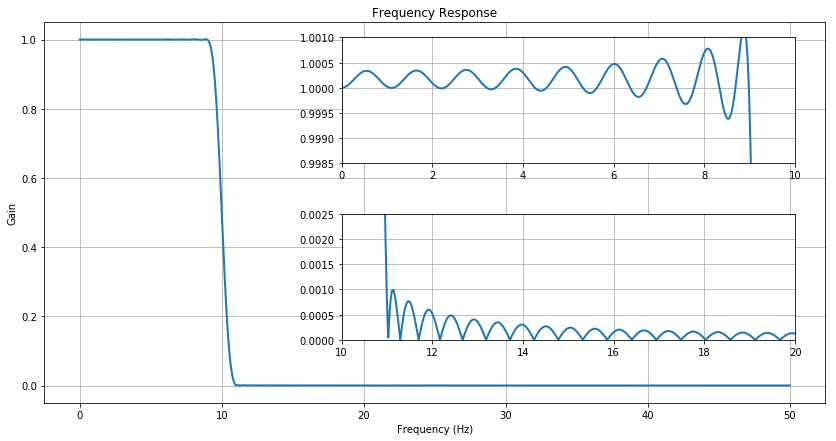

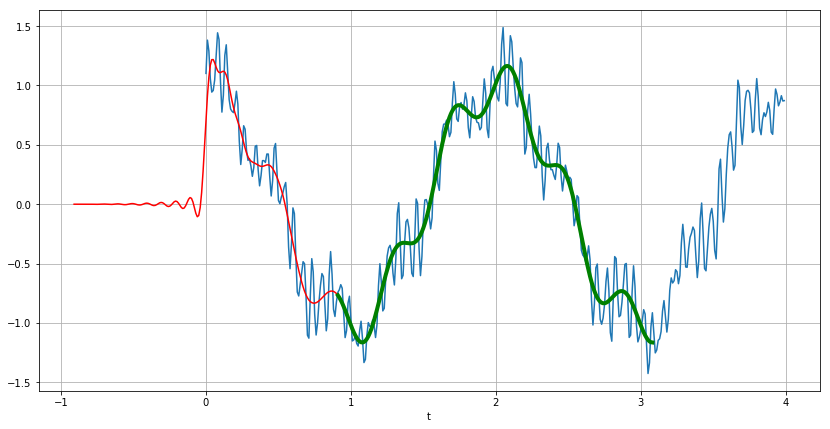

In [2]:
width = 2.0/nyq_rate
ripple_db = 60.0
cutoff_hz = 10.0

runFilter()
plotFilterFigs()

## Every filter introduces some delay in the signal when you apply it

So far we have been able to move the filtered signal back in time by `delay` because we already have all of the data, but in a real time application, the middle of the filter will be about N/2 into the past, so your estimate will be that far behind. Here's what it would look like without the delay.


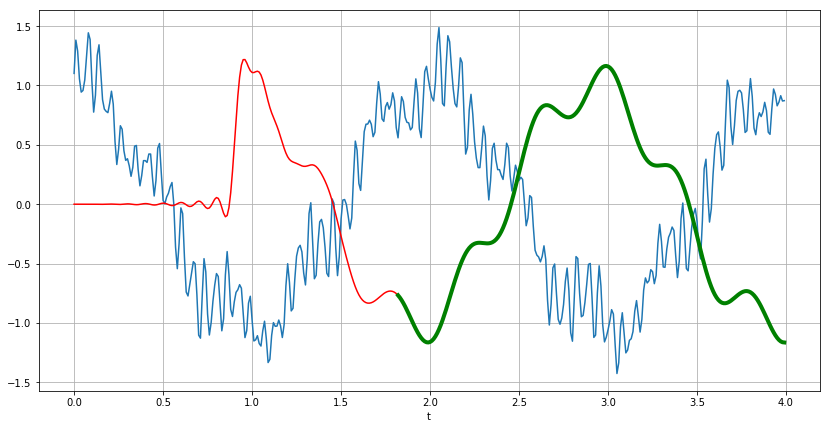

In [3]:
delay = 0.5 * (N-1) / sample_rate
delay = 0
plotResults()

## How does it compare with smoothing?

Try a wide rolloff, without too high a ripple_db suppression so you can get fewer taps. Then try an exponential smoothing approach with a time constant about equal to the inverse of the rolloff frequency. 

The filter gives you two parameters to adjust, while the smoothing lumps it all in a single time constant.

Smoothing is very easy to do in an Arduino sketch.

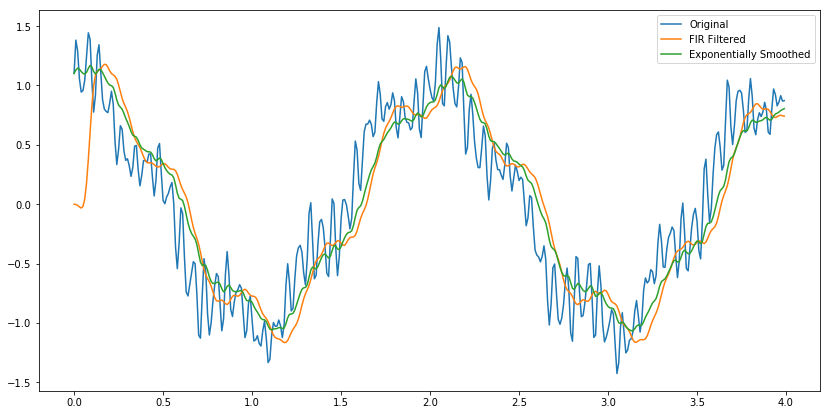

In [4]:
width = 20.0/nyq_rate
ripple_db = 60.0
cutoff_hz = 10.0
tau = 1/cutoff_hz

runFilter()

def expSmooth(t,T,tau):        # returns a smoothed version of T with time constant tau
    Ts = T.copy()              # another vector for the smoothed data
    for i in range(1,len(Ts)): # here's where the actual smoothing happens
        dt = t[i]-t[i-1]
        w = min(dt/tau,1)
        Ts[i] = Ts[i-1] * (1-w) + T[i] * w
    return Ts                  # return the smoothed data


sm_x = expSmooth(t,x,tau)

plot(t,x,label = 'Original')
plot(t,filtered_x,label = 'FIR Filtered')
plot(t,sm_x,label = 'Exponentially Smoothed')
legend()


This segment just makes it clear what the `lfilter()` function is doing when it convolves the taps with x. It takes the N taps, applies the last one to the current x value, and all the earlier ones to the older x values, then puts the result in the current filtered value. It ignores some of the results at the beginning where the taps don't fully overlap x, essentially padding the start of the sequence with zeros. https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.lfilter.html

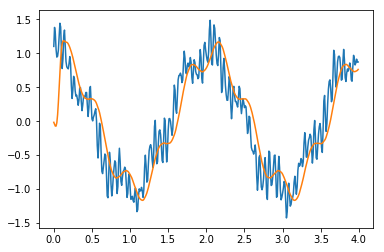

In [63]:
hf_x = x.copy()
l = len(taps)
for i in range(0,nsamples):
    hf_x[i] = 0
    for j in range(0,N):
        k = i - (N-1) + j
        if(k >= 0): hf_x[i] += taps[j] * x[k]
plot(t,x,t,hf_x)